In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

Bay area bike share data on Google BigQuery: 
https://bigquery.cloud.google.com/table/bigquery-public-data:san_francisco.bikeshare_trips

In [3]:
# Access for Google BigQuery
from pandas.io import gbq
project_id = 'fluted-galaxy-165204'

In [4]:
import scipy.stats as stats
import sklearn

In [5]:
df_trips = pd.DataFrame.from_csv('trip.csv')

In [6]:
df_trips = df_trips.sort_values('trip_id')
df_trips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
841272,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,94114,Subscriber
739741,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,94703,Subscriber
691514,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,94115,Subscriber
832324,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,94122,Subscriber
437635,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,94597,Subscriber


## Predicting bike usage 

#### 1. Daily bike usage prediction
We start by predicting the daily bike usage. We would like to define the daily usage as the number of trips that "occurs" in a day, one intuitive way is to count the number of trips that start in a day. However, one potential problem is that some trips may span across days (either a very long time period or a trip occurring around midnight).

In [7]:
df_trips.start_date = pd.to_datetime(df_trips.start_date)
df_trips.end_date = pd.to_datetime(df_trips.end_date)

In [8]:
cross_day = sum(df_trips.start_date.dt.date != df_trips.end_date.dt.date)
print "Number of cross-day trips: ", cross_day
print "Number of total trips: ", len(df_trips)
print "Percentage of cross-day trips: ", float(cross_day) / len(df_trips) * 100

Number of cross-day trips:  2583
Number of total trips:  983648
Percentage of cross-day trips:  0.262593936042


We could see that less than 0.3% of trips are cross-day trips. Let's use the start date to define the daily bike usage for now.

In [9]:
df_trips_day = df_trips[['duration_sec', 'start_date']]
df_trips_day['rides'] = 1
df_daily = df_trips_day.groupby(df_trips_day.start_date.dt.date).sum()

/Users/changhengwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
weather1 = pd.DataFrame.from_csv('data/201402_babs_open_data/201402_weather_data.csv', index_col=None)
weather2 = pd.DataFrame.from_csv('data/201408_babs_open_data/201408_weather_data.csv', index_col=None)
weather3 = pd.DataFrame.from_csv('data/babs_open_data_year_2/201508_weather_data.csv', index_col=None)
weather4 = pd.DataFrame.from_csv('data/babs_open_data_year_3/201608_weather_data.csv', index_col=None)

In [11]:
weather2.columns = weather1.columns
weather3.columns = weather1.columns
weather4.columns = weather1.columns
weather1 = weather1[~weather1.Date.duplicated()].set_index('Date')
weather2 = weather2[~weather2.Date.duplicated()].set_index('Date')
weather3 = weather3[~weather3.Date.duplicated()].set_index('Date')
weather4 = weather4[~weather4.Date.duplicated()].set_index('Date')

weather = pd.concat([weather1, weather2, weather3, weather4], axis=0)
weather.head()

,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_Pressure_In,...,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Cloud_Cover,Events,Wind_Dir_Degrees,zip
Date,,,,,,,,,,,,,,,,,,,,,
8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,30.07,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,30.05,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,30.00,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,29.96,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [12]:
weather = weather.reset_index()
weather.Date = pd.to_datetime(weather.Date).dt.date
weather.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,...,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Cloud_Cover,Events,Wind_Dir_Degrees,zip
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [13]:
weather = weather.rename(columns = {'Date':'start_date'})

In [14]:
df_daily = df_daily.reset_index()
df_daily.head()

,start_date,duration_sec,rides
0,2013-08-29,1167850,748
1,2013-08-30,1930037,714
2,2013-08-31,2342473,640
3,2013-09-01,2404578,706
4,2013-09-02,1543638,661


In [15]:
df_daily['day'] = pd.to_datetime(df_daily.start_date).dt.weekday
df_daily['week'] = pd.to_datetime(df_daily.start_date).dt.week
df_daily['month'] = pd.to_datetime(df_daily.start_date).dt.month
df_daily.head()

,start_date,duration_sec,rides,day,week,month
0,2013-08-29,1167850,748,3,35,8
1,2013-08-30,1930037,714,4,35,8
2,2013-08-31,2342473,640,5,35,8
3,2013-09-01,2404578,706,6,35,9
4,2013-09-02,1543638,661,0,36,9


In [16]:
df_daily_weather = pd.merge(df_daily, weather, on='start_date')
df_daily_weather.head()

,start_date,duration_sec,rides,day,week,month,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,...,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Max_Gust_Speed_MPH,Precipitation_In,Cloud_Cover,Events,Wind_Dir_Degrees,zip
0,2013-08-29,1167850,748,3,35,8,74.0,68.0,61.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,1930037,714,4,35,8,78.0,69.0,60.0,61.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,2342473,640,5,35,8,71.0,64.0,57.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,2404578,706,6,35,9,74.0,66.0,58.0,60.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,1543638,661,0,36,9,75.0,69.0,62.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


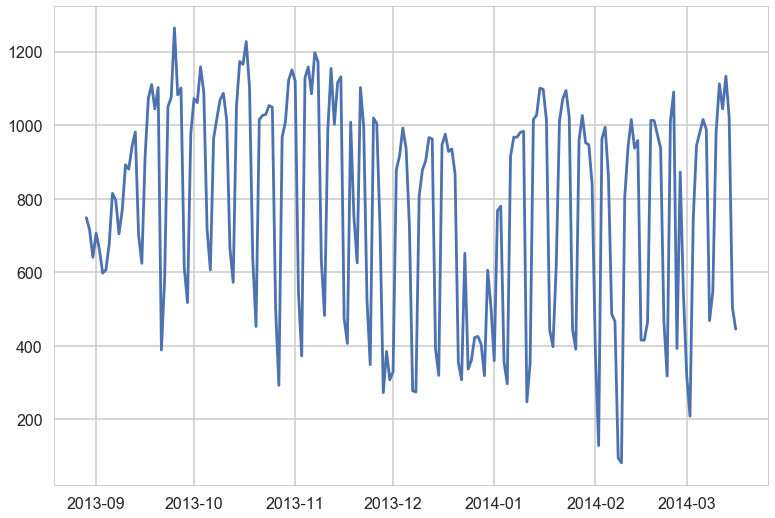

In [17]:
# Plot the daily usage for the first 200 days
plt.plot(df_daily.start_date[:200], df_daily.rides[:200])

In [18]:
len(df_daily)

1099

In [19]:
# Split train and test data
X_train = df_daily[['day', 'week', 'month']][50:-50]
X_test = df_daily[['day', 'week', 'month']][-50:]
Y_train = df_daily['rides'][50:-50]
Y_test = df_daily['rides'][-50:]
date_test = df_daily['start_date'][-50:]

#### Linear regression with scikit learn

In [20]:
# Fit linear regression with scikit learn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
predicted = lm.predict(X_test)

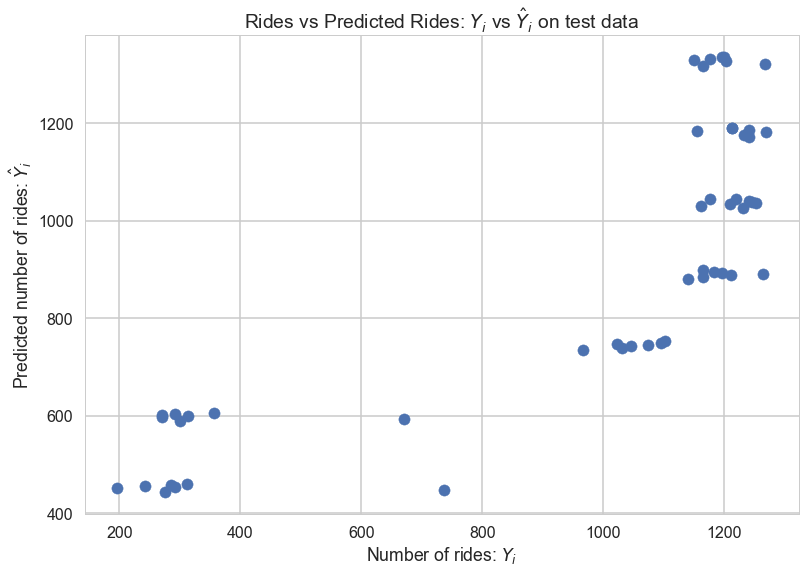

In [22]:
plt.scatter(Y_test, predicted)
plt.xlabel("Number of rides: $Y_i$")
plt.ylabel("Predicted number of rides: $\hat{Y}_i$")
plt.title("Rides vs Predicted Rides: $Y_i$ vs $\hat{Y}_i$ on test data")

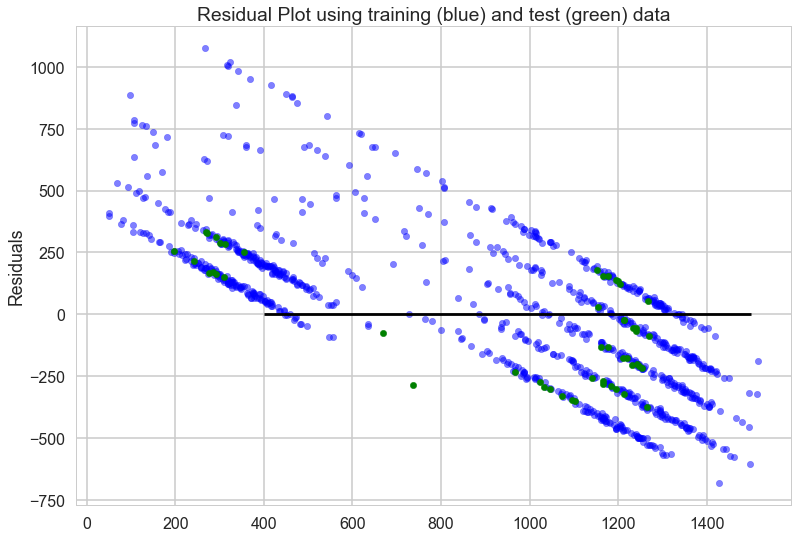

In [23]:
plt.scatter(Y_train, lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(Y_test, lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=400, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

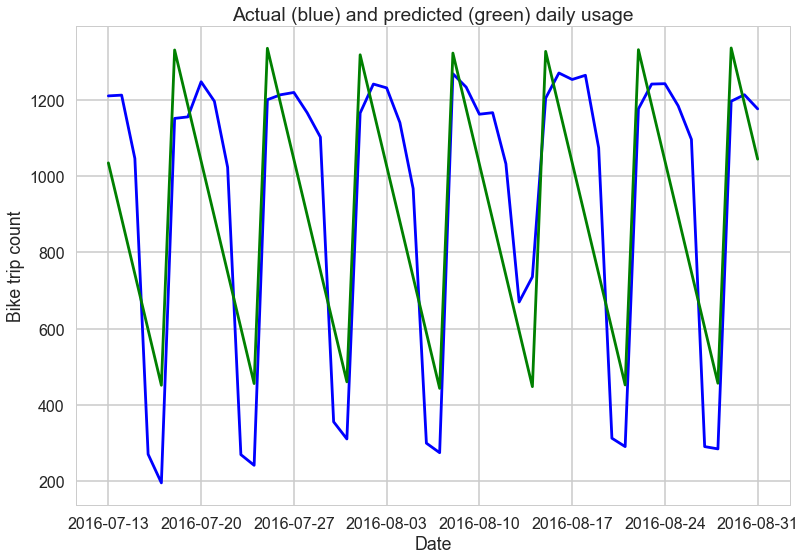

In [24]:
plt.plot(date_test, Y_test, c='b')
plt.plot(date_test, predicted, c='g')
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')

In [25]:
truth = Y_test
predict = predicted
mse = np.mean((truth-predict)**2)
print 'Mean squared error = ', mse

Mean squared error =  51433.04428


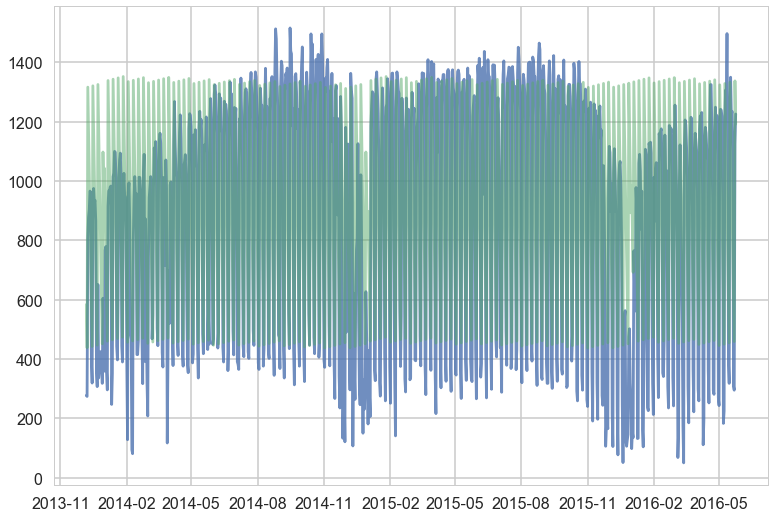

In [26]:
date_range = range(100, 1000)
plt.plot(df_daily.start_date[date_range], df_daily.rides[date_range], alpha=0.8)
plt.plot(df_daily.start_date[date_range], lm.predict(df_daily[['day', 'week', 'month']].loc[date_range, :]), alpha=0.5)

#### Support vector regression with scikit learn

In [27]:
from sklearn.svm import SVR

In [28]:
svr = SVR(C=1e4, gamma=0.1)
svr.fit(X_train, Y_train)

SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

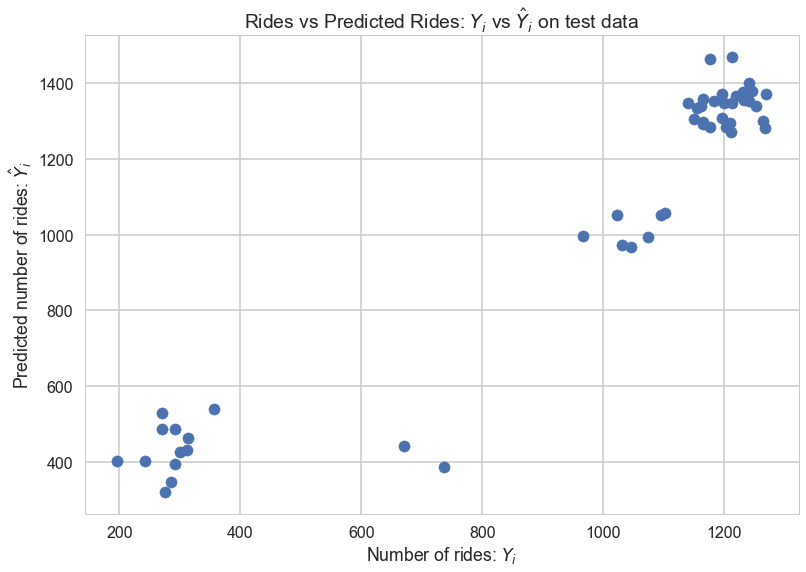

In [29]:
predicted_svr = svr.predict(X_test)
plt.scatter(Y_test, predicted_svr)
plt.xlabel("Number of rides: $Y_i$")
plt.ylabel("Predicted number of rides: $\hat{Y}_i$")
plt.title("Rides vs Predicted Rides: $Y_i$ vs $\hat{Y}_i$ on test data")

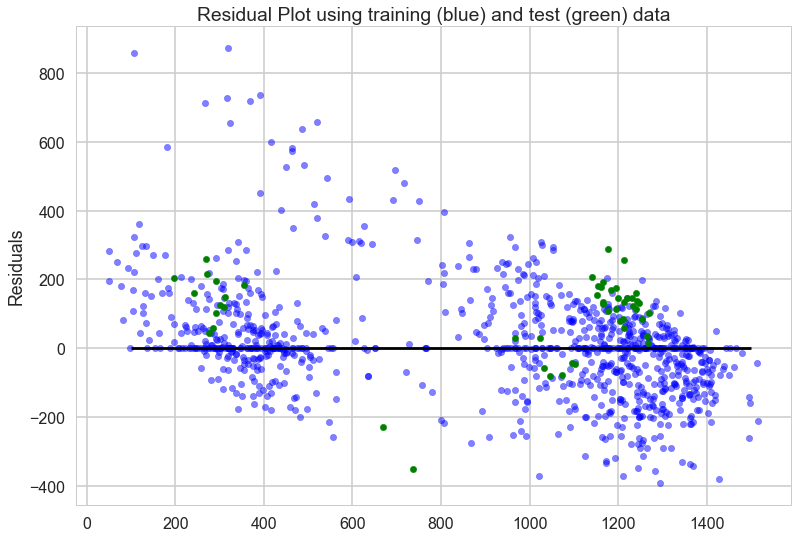

In [30]:
plt.scatter(Y_train, (svr.predict(X_train) - Y_train), c='b', s=40, alpha=0.5)
plt.scatter(Y_test, (svr.predict(X_test) - Y_test), c='g', s=40)
plt.hlines(y = 0, xmin=100, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

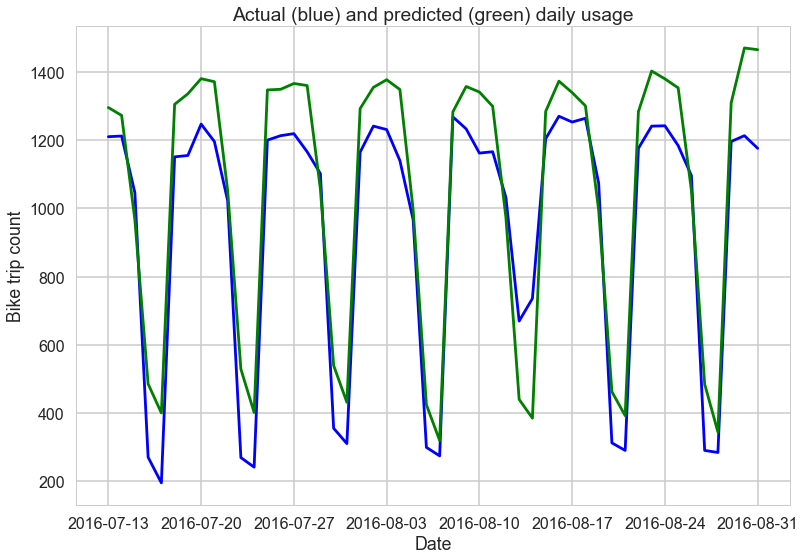

In [31]:
plt.plot(date_test, Y_test, c='b')
plt.plot(date_test, predicted_svr, c='g')
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')

In [32]:
truth = Y_test
predict = predicted_svr
mse = np.mean((truth-predict)**2)
print 'Mean squared error = ', mse

Mean squared error =  23311.270821


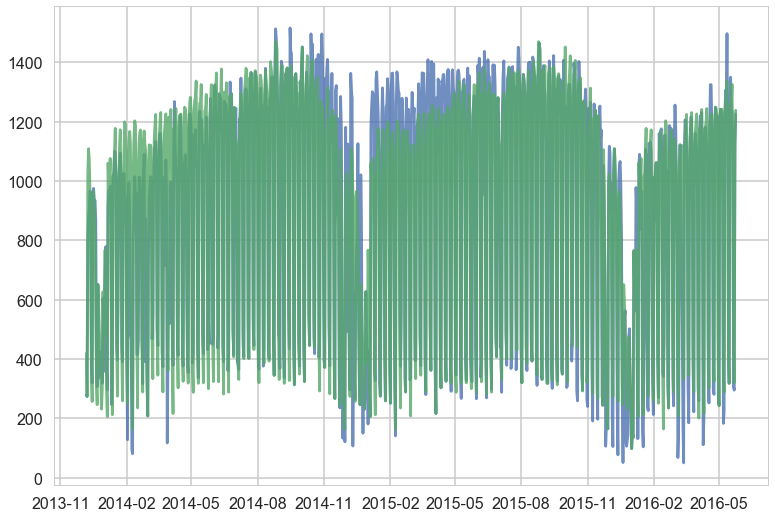

In [33]:
date_range = range(100, 1000)
plt.plot(df_daily.start_date[date_range], df_daily.rides[date_range], alpha=0.8)
plt.plot(df_daily.start_date[date_range], svr.predict(df_daily[['day', 'week', 'month']].loc[date_range, :]), alpha=0.8)

#### Cross-validation with SVR

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [35]:
X = df_daily[['start_date', 'day', 'week', 'month']]
Y = df_daily['rides']

In [36]:
# Randomly select 40% of data as test set
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
X_train = X_train_raw[['day', 'week', 'month']]
X_test = X_test_raw[['day', 'week', 'month']]

In [37]:
# Tune hyper parameter with cross validation
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
                     'C': [1, 10, 100, 1e3, 1e4]}]
clf = GridSearchCV(SVR(C=1), tuned_parameters, cv=5, scoring='r2')
clf.fit(X_train, Y_train)
print(clf.best_params_)

{'kernel': 'rbf', 'C': 1000.0, 'gamma': 0.1}


In [38]:
# Train with the optimal parameters as determined through cross validation
svr = SVR(C=1e3, gamma=0.1)
svr.fit(X_train, Y_train)
predicted_svr = svr.predict(X_test)

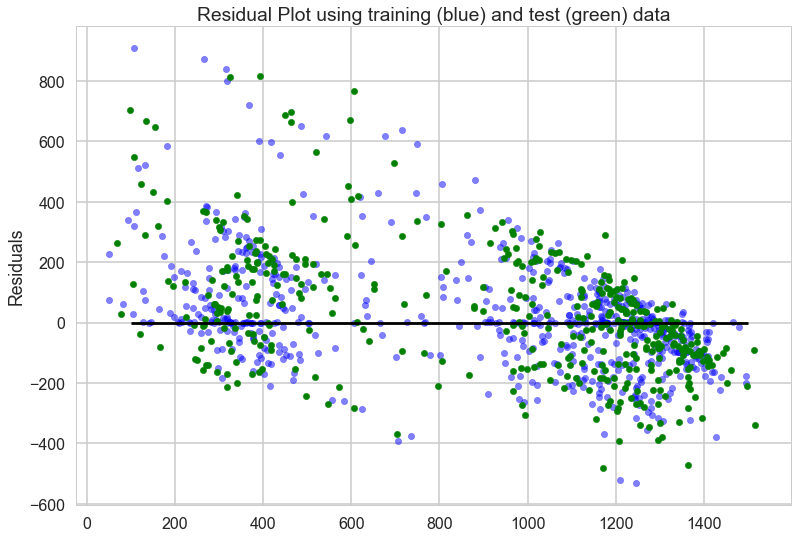

In [39]:
plt.scatter(Y_train, (svr.predict(X_train) - Y_train), c='b', s=40, alpha=0.5)
plt.scatter(Y_test, (svr.predict(X_test) - Y_test), c='g', s=40)
plt.hlines(y = 0, xmin=100, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

In [40]:
date_test = X_test_raw['start_date']

result = pd.DataFrame(date_test)
result['truth'] = Y_test
result['predicted'] = predicted_svr
result = result.sort_values('start_date')

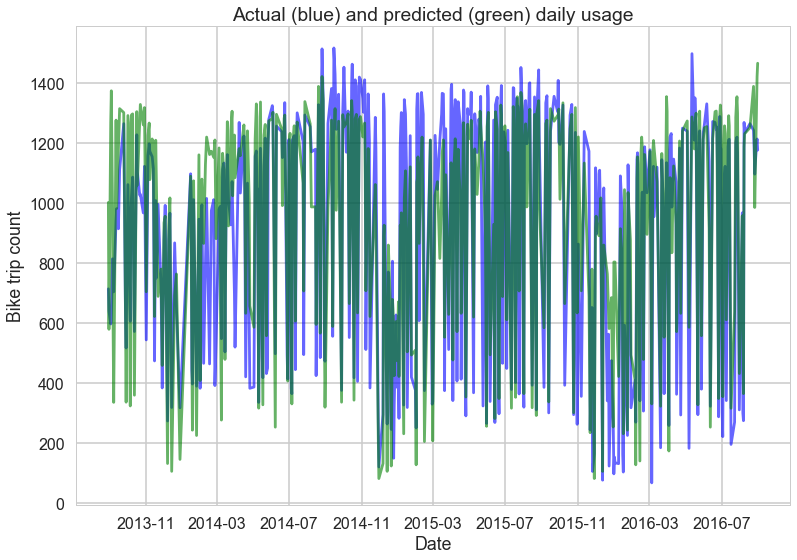

In [41]:
plt.figure()
plt.plot(result.start_date, result.truth, c='b', alpha=0.6)
plt.plot(result.start_date, result.predicted, c='g', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')

In [42]:
truth = result.truth
predict = result.predicted
mse = np.mean((truth-predict)**2)
print 'Mean squared error = ', mse

Mean squared error =  43762.8646791


#### Cross validation with time series awareness

In [43]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

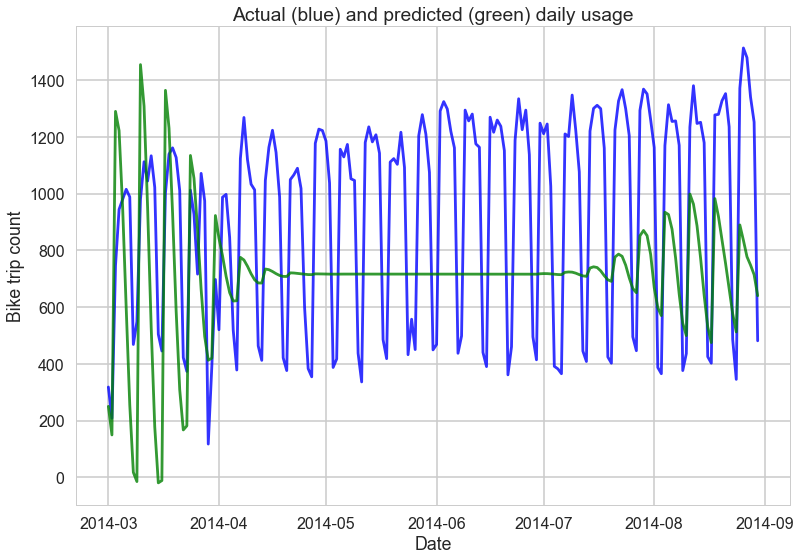

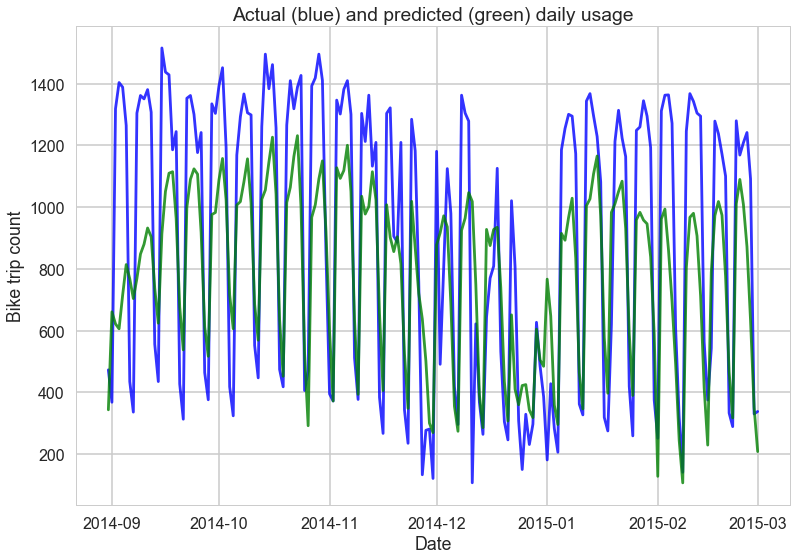

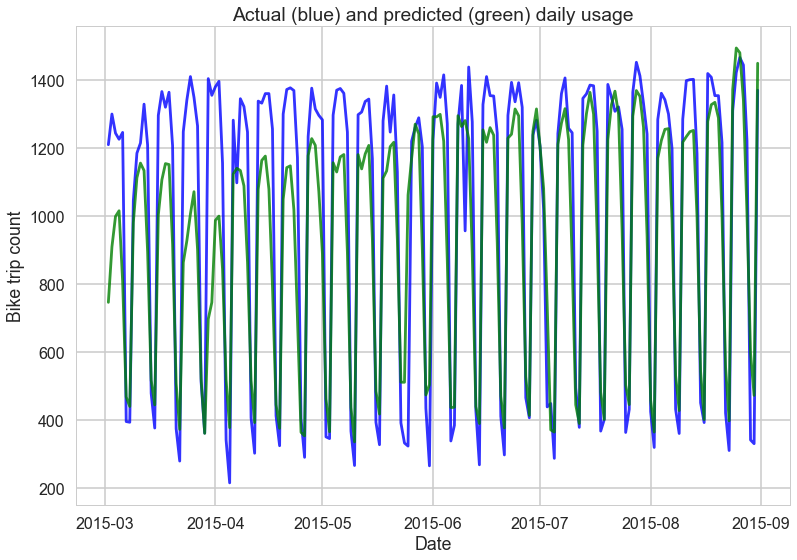

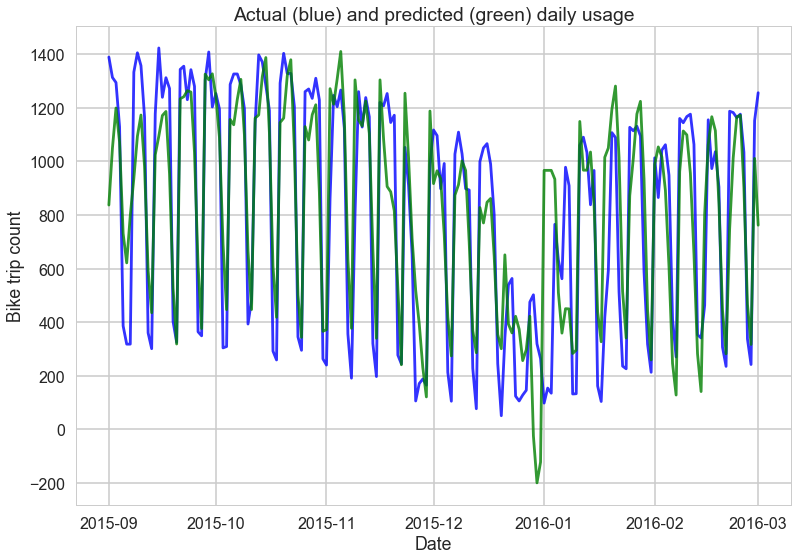

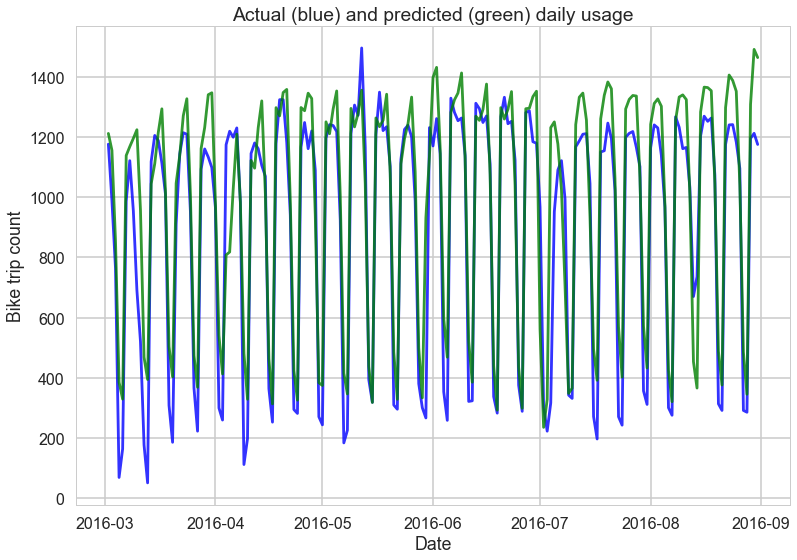

In [44]:
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_raw, X_test_raw = X.loc[train_index,:], X.loc[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]
    X_train = X_train_raw[['day', 'week', 'month']]
    X_test = X_test_raw[['day', 'week', 'month']]
    
    svr = SVR(C=1e4, gamma=0.1)
    svr.fit(X_train, Y_train)
    predicted_svr = svr.predict(X_test)
    
    date_test = X_test_raw['start_date']

    plt.figure()
    plt.plot(date_test, Y_test, c='b', alpha=0.8)
    plt.plot(date_test, predicted_svr, c='g', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Bike trip count')
    plt.title('Actual (blue) and predicted (green) daily usage')

#### Adding weather features

In [45]:
X = df_daily_weather[['start_date', 'day', 'week', 'month', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF']]
Y = df_daily_weather['rides']

In [46]:
X_train_raw = X[50:-50]
X_test_raw = X[-50:]
Y_train = Y[50:-50]
Y_test = Y[-50:]
X_train = X_train_raw[['day', 'week', 'month', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF']]
X_test = X_test_raw[['day', 'week', 'month', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF']]

In [47]:
# Determine if there is missing data
X_train[X_train.isnull().any(axis=1)]

,day,week,month,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF


In [48]:
X_test[X_test.isnull().any(axis=1)]

,day,week,month,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF


In [49]:
# Fill missing data with padding (not ideal)
X_train = X_train.fillna(method='pad')
X_test = X_test.fillna(method='pad')

In [50]:
# Tune hyper parameter with cross validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
                     'C': [1, 10, 100, 1e3, 1e4]}]
clf = GridSearchCV(SVR(C=1), tuned_parameters, cv=5, scoring='r2')
clf.fit(X_train, Y_train)
print(clf.best_params_)

{'kernel': 'rbf', 'C': 1000.0, 'gamma': 0.01}


In [51]:
# Train with the optimal parameters as determined through cross validation
svr = SVR(C=1e4, gamma=0.01)
svr.fit(X_train, Y_train)
predicted_svr = svr.predict(X_test)

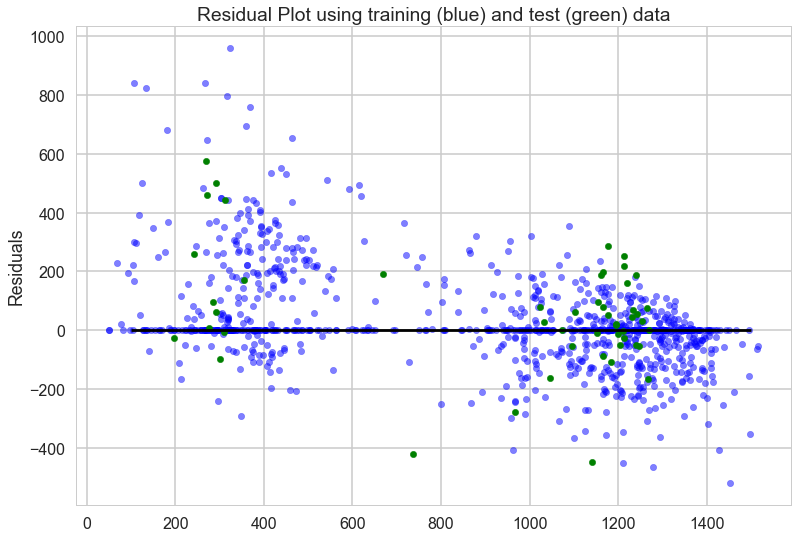

In [52]:
plt.scatter(Y_train, (svr.predict(X_train) - Y_train), c='b', s=40, alpha=0.5)
plt.scatter(Y_test, (svr.predict(X_test) - Y_test), c='g', s=40)
plt.hlines(y = 0, xmin=100, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

In [53]:
# Aggregate the result and prepare for plot
date_test = X_test_raw['start_date']

result = pd.DataFrame(date_test)
result['truth'] = Y_test
result['predicted'] = predicted_svr
result = result.sort_values('start_date')

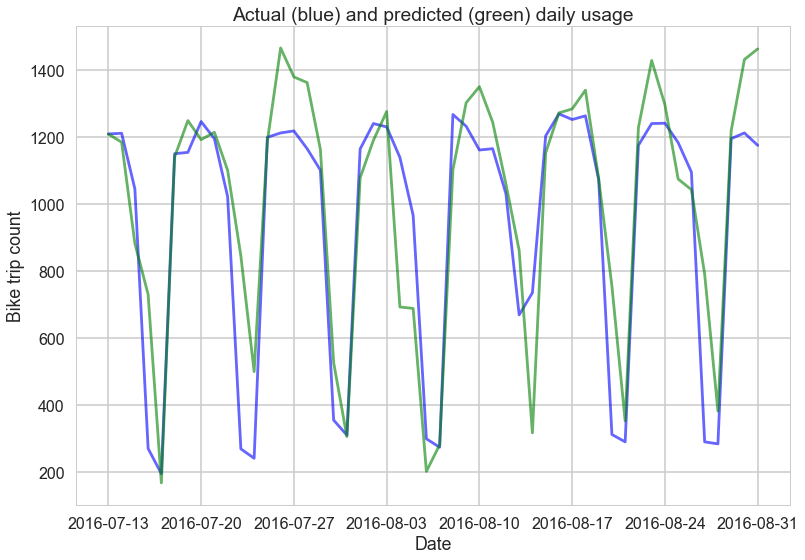

In [54]:
# Plot predicted result and compare with ground truth
plt.figure()
plt.plot(result.start_date, result.truth, c='b', alpha=0.6)
plt.plot(result.start_date, result.predicted, c='g', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')

In [55]:
truth = result.truth
predict = result.predicted
mse = np.mean((truth-predict)**2)
print 'Mean squared error = ', mse

Mean squared error =  41201.3571485


#### Station by station prediction

In [56]:
df_trips_day = df_trips[['duration_sec', 'start_date', 'start_station_id']]
df_trips_day.start_date = df_trips_day.start_date.dt.date
df_trips_day['rides'] = 1
df_station_daily = df_trips_day.groupby(['start_date', 'start_station_id']).sum()

/Users/changhengwang/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/changhengwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [57]:
df_station_daily.head()

duration_sec  rides
start_date start_station_id                     
2013-08-29 2                         4392      5
           3                         5605      9
           4                         1057      3
           5                         1178      3
           6                         2012      4

In [58]:
df_station_daily = df_station_daily.reset_index()
df_station_daily.head()
#df_station_daily[df_station_daily.start_station_id == 2]

,start_date,start_station_id,duration_sec,rides
0,2013-08-29,2,4392,5
1,2013-08-29,3,5605,9
2,2013-08-29,4,1057,3
3,2013-08-29,5,1178,3
4,2013-08-29,6,2012,4


In [59]:
test_start_date = df_daily.start_date[len(df_daily)-50]

In [60]:
df_station_daily['day'] = pd.to_datetime(df_station_daily.start_date).dt.weekday
df_station_daily['week'] = pd.to_datetime(df_station_daily.start_date).dt.week
df_station_daily['month'] = pd.to_datetime(df_station_daily.start_date).dt.month

X = df_station_daily[['start_date', 'start_station_id', 'day', 'week', 'month']]
Y = df_station_daily['rides']

In [61]:
X.head()

,start_date,start_station_id,day,week,month
0,2013-08-29,2,3,35,8
1,2013-08-29,3,3,35,8
2,2013-08-29,4,3,35,8
3,2013-08-29,5,3,35,8
4,2013-08-29,6,3,35,8


In [62]:
X_train_raw = X[X.start_date < test_start_date]
X_test_raw = X[X.start_date >= test_start_date]
Y_train = Y[X.start_date < test_start_date]
Y_test = Y[X.start_date >= test_start_date]
X_train = X_train_raw[['start_station_id', 'day', 'week', 'month']]
X_test = X_test_raw[['start_station_id', 'day', 'week', 'month']]

In [ ]:
# Tune hyper parameter with cross validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
                     'C': [1, 10, 100, 1e3, 1e4]}]
clf = GridSearchCV(SVR(C=1), tuned_parameters, cv=3, scoring='r2')
clf.fit(X_train, Y_train)
print(clf.best_params_)

In [ ]:
# Train with the optimal parameters as determined through cross validation
svr = SVR(C=1e4, gamma=0.01)
svr.fit(X_train, Y_train)
predicted_svr = svr.predict(X_test)

In [ ]:
plt.scatter(Y_train, (svr.predict(X_train) - Y_train), c='b', s=40, alpha=0.5)
plt.scatter(Y_test, (svr.predict(X_test) - Y_test), c='g', s=40)
plt.hlines(y = 0, xmin=100, xmax = 1500)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

In [ ]:
# Aggregate the result and prepare for plot
result = X_test

#result = pd.DataFrame(date_test)
result['truth'] = Y_test
result['predicted'] = predicted_svr
result = result.sort_values('start_date')

In [ ]:
# Plot predicted result and compare with ground truth
plt.figure()
plt.plot(result.start_date, result.truth, c='b', alpha=0.6)
plt.plot(result.start_date, result.predicted, c='g', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Bike trip count')
plt.title('Actual (blue) and predicted (green) daily usage')